# ELEN4022 - Lab 2

#### 1924564

#### 19-04-2024

## Introduction

The goal of this lab is to create an adder circuit in qiskit that can add 3 and 5 qubits together. The result is an adder circuit that can handle n qubits. The circuit for a 3 qubit addition is transpiled and sent to the least busy IBM quantum hardware to yield a result. The result is then analyzed.

## Backround

The half adder and full adder circuit are made up a combination of XOR and AND gates. A full adder

In [76]:
from qiskit import *
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.primitives import Estimator
from qiskit_ibm_provider import IBMProvider
# from qiskit.providers.ibmq import IBMQ
# from qiskit import IBMQ

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

import matplotlib.pyplot as plt

In [79]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    )

In [80]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Construction of a Full Adder Circuit.

Below is code showing the SUM, CARRY and FULLADDER funtions. These functions can deal with binary numbers of length n. 

In [87]:

# Circuit function creates qNum1 circuit with both quantum and classical registers.
# Input is two binary numbers to be added together.
# Outputs the qNum1, B, Carry and Classical registers and Quantum circuit.
def createCircuit(num1, num2):
    length1 = len(num1)
    length2 = len(num2)
    if length1 > length2:
        n = length1
    else:
        n = length2
    # initialise empty registers
    qNum1 = QuantumRegister(n) # quantum registers for num1
    qNum2 = QuantumRegister(n+1) # quantum registers for num2
    carryBits = QuantumRegister(n) 
    classicalBits = ClassicalRegister(n+1) #Classical output
    qc = QuantumCircuit(qNum1, qNum2, carryBits, classicalBits)

    # loop to initialise registers according to input binary numbers on qNum1
    for i in range(length1):
        # check if the input is 1 digit
        if num1[i] == "1":
           # if yes, flip corresponding register.
           qc.x(qNum1[length1 - (i+1)]) 
    # perform same loop on qNum2
    for i in range(length2):
       if num2[i] == "1":
          qc.x(qNum2[length2 - (i+1)]) 

    return qNum1,qNum2,carryBits,classicalBits,qc,n




# Calculate the carry bits
def CARRY(n, qNum1, qNum2, carryBits, qc):
    for i in range(n-1):
        qc.ccx(qNum1[i], qNum2[i], carryBits[i+1])
        qc.cx(qNum1[i], qNum2[i])
        qc.ccx(carryBits[i], qNum2[i], carryBits[i+1])

    qc.ccx(qNum1[n-1], qNum2[n-1], qNum2[n])
    qc.cx(qNum1[n-1], qNum2[n-1])
    qc.ccx(carryBits[n-1], qNum2[n-1], qNum2[n])

    #Reversing the gate operation performed on qNum2[n-1]
    qc.cx(carryBits[n-1], qNum2[n-1])

    return n, qNum1, qNum2, carryBits, qc



def SUM(n, qNum1, qNum2, carryBits, qc):
    for i in range(n-1):
        #Reversing the gate operations performed during the carry gate implementations
        qc.ccx(carryBits[(n-2)-i], qNum2[(n-2)-i], carryBits[(n-1)-i])
        qc.cx(qNum1[(n-2)-i], qNum2[(n-2)-i])
        qc.ccx(qNum1[(n-2)-i], qNum2[(n-2)-i], carryBits[(n-1)-i])

        #SUM Gate
        qc.cx(carryBits[(n-2)-i], qNum2[(n-2)-i])
        qc.cx(qNum1[(n-2)-i], qNum2[(n-2)-i])
    return n, qNum1, qNum2, carryBits, qc


def FULLADDER(num1, num2):
    qNum1, qNum2, carryBits, cl, qc, n = createCircuit(num1, num2)
    n, qNum1, qNum2, carryBits, qc= CARRY(n, qNum1, qNum2, carryBits, qc)
    n, qNum1, qNum2, carryBits, qc = SUM(n, qNum1, qNum2, carryBits, qc)
    return n,qNum2,cl,qc

## Simulating Summing 3 and 5 qubit numbers. 

The below code first performs the sum of two three-qubit numbers. It then performs the sum of two three-qubit numbers. These circuits for each of these results are drawn and simulated.

In [88]:
# Simulate 3 qubit adder
num1 = "101"
num2 = "010"


n, qNumSum, classicalBits, qc3 = FULLADDER(num1, num2)

#Measure qubits and store results in classical register cl
for i in range(n+1):
    qc3.measure(qNumSum[i], classicalBits[i])


backend = Aer.get_backend('qasm_simulator', shots = 2)
job = backend.run(qc3)
result = job.result()                                                               
print(result.get_counts())


{'0111': 1024}


{'0111': 10000}


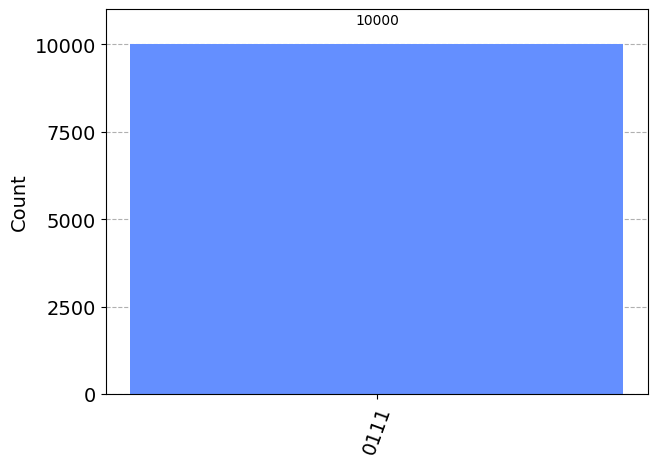

In [89]:
# To simulate

service = QiskitRuntimeService(channel="ibm_quantum")
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(qc3, shots=10000).result().get_counts()

# Print the counts
print(counts)

# Plot the histogram of the counts
plot_histogram(counts)

In [91]:
# simulate 5 qubit adder
num1 = "11010"
num2 = "00011"


n, qNumSum, classicalBits, qc5 = FULLADDER(num1, num2)

#Measure qubits and store results in classical register cl
for i in range(n+1):
    qc5.measure(qNumSum[i], classicalBits[i])


backend = Aer.get_backend('qasm_simulator', shots = 2)
job = backend.run(qc5)
result = job.result()                                                               
print(result.get_counts())

{'011101': 1024}


{'011101': 10000}


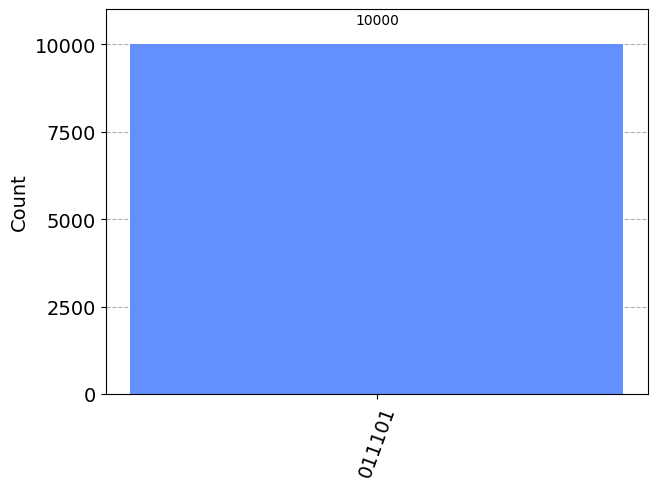

In [93]:
# To simulate

service = QiskitRuntimeService(channel="ibm_quantum")
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(qc5, shots=10000).result().get_counts()

# Print the counts
print(counts)

# Plot the histogram of the counts
plot_histogram(counts)

In [ ]:
# qc.measure_all()
# qc.draw(output="mpl", style="iqp")

## Running a 3 Qubit adder on IBM Quantum Hardware.

The three qubit circuit is transpiled and sent to the least busy IBM quantum hardware to run the transpiled circuit.
The result is shows a distribution of potential sums. The simulator yielded a value of 111 whereas the quantum hardware shows a distribution of values. Since there is a high error when using quantum computers this is to be expected. The distribution shows a higher count for values with three '1' digits or higher in them and an average count lower for values with two '1's or less.

{'011011': 241, '000110': 75, '100111': 72, '100001': 91, '001010': 70, '111101': 241, '111000': 282, '011101': 200, '110110': 217, '011110': 202, '010011': 214, '100010': 70, '101001': 84, '000100': 71, '101010': 71, '101011': 80, '000000': 63, '100100': 78, '110000': 261, '110111': 222, '110100': 250, '111110': 247, '001100': 71, '011000': 238, '000001': 82, '001001': 67, '100000': 92, '000010': 64, '110001': 275, '010111': 221, '101101': 79, '001011': 72, '001111': 71, '010101': 237, '010100': 247, '010001': 229, '010000': 238, '110011': 248, '001110': 65, '110101': 290, '111010': 256, '110010': 257, '100110': 47, '111001': 295, '101110': 72, '000011': 66, '000101': 76, '011010': 227, '101000': 83, '011111': 199, '100011': 81, '101111': 80, '001101': 53, '100101': 79, '010110': 198, '011100': 221, '011001': 216, '101100': 84, '111011': 247, '001000': 85, '000111': 67, '111100': 271, '111111': 249, '010010': 203}


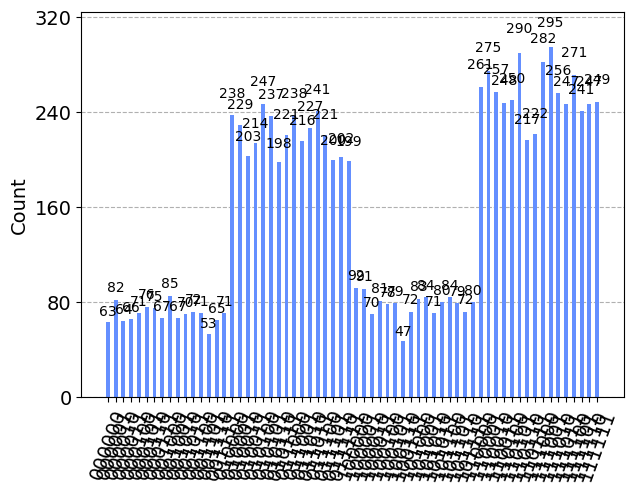

In [96]:
transpiled_qc = transpile(qc3, backend=backend)
service = QiskitRuntimeService()
realBackend = service.least_busy(simulator=False, operational=True)
counts = realBackend.run(transpiled_qc, shots=10000).result().get_counts()

# Print the counts
print(counts)

# Plot the histogram of the counts
plot_histogram(counts)

{'010111': 167, '101101': 268, '011100': 239, '000000': 76, '011110': 234, '000010': 77, '010010': 201, '111001': 94, '011111': 229, '001101': 101, '111100': 88, '010000': 176, '110001': 67, '011011': 221, '000110': 96, '111011': 104, '001001': 99, '100111': 212, '011000': 244, '111110': 84, '100110': 205, '101011': 269, '100000': 226, '010011': 193, '100011': 204, '110000': 95, '010100': 186, '111010': 88, '100010': 190, '110101': 79, '011001': 242, '100001': 216, '010110': 173, '000111': 66, '110100': 66, '110111': 69, '110110': 62, '011010': 221, '000100': 66, '111111': 90, '100100': 229, '010101': 173, '000001': 89, '001010': 94, '111000': 114, '001111': 94, '101010': 280, '101000': 263, '001100': 90, '001110': 115, '110010': 72, '010001': 176, '011101': 230, '101001': 284, '111101': 76, '000011': 84, '001000': 102, '001011': 118, '101110': 290, '101111': 254, '100101': 238, '101100': 294, '110011': 81, '000101': 77}


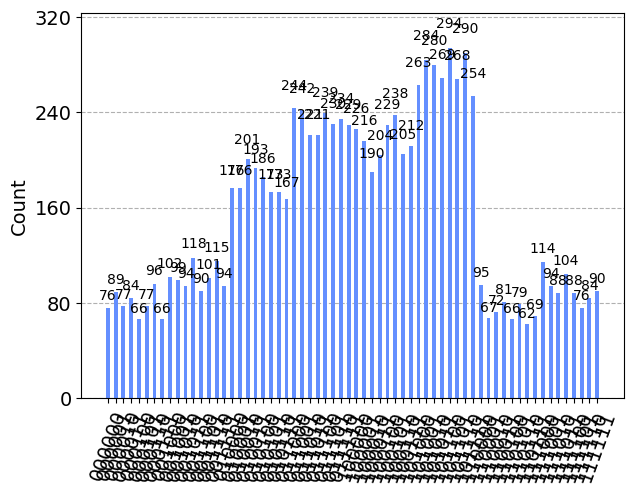

In [105]:
transpiled_qc = transpile(qc5, backend=backend)
service = QiskitRuntimeService()
realBackend = service.least_busy(simulator=False, operational=True)
counts = realBackend.run(transpiled_qc, shots=10000).result().get_counts()

# Print the counts
print(counts)

# Plot the histogram of the counts
plot_histogram(counts)